# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse
import PyPDF2
import pdfplumber

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Text Processing
import re
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import pyresparser
from pyresparser import ResumeParser
from openpyxl import load_workbook

# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
import torch

# Model training and evaluation
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /Users/joshua/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/joshua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joshua/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Section 1

# Dataset Analysis & Preprocessing

In [ ]:
resume_df = pd.read_csv("Resume.csv")
resume_df

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR
...,...,...,...,...
2479,99416532,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2480,24589765,"GOVERNMENT RELATIONS, COMMUNICATIONS ...","<div class=""fontsize fontface vmargins hmargin...",AVIATION
2481,31605080,GEEK SQUAD AGENT Professional...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION


In [ ]:
category_counts = resume_df['Category'].value_counts()
category_counts.reset_index()

,Category,count
0,INFORMATION-TECHNOLOGY,120
1,BUSINESS-DEVELOPMENT,120
2,FINANCE,118
3,ADVOCATE,118
4,ACCOUNTANT,118
5,ENGINEERING,118
6,CHEF,118
7,AVIATION,117
8,FITNESS,117
9,SALES,116


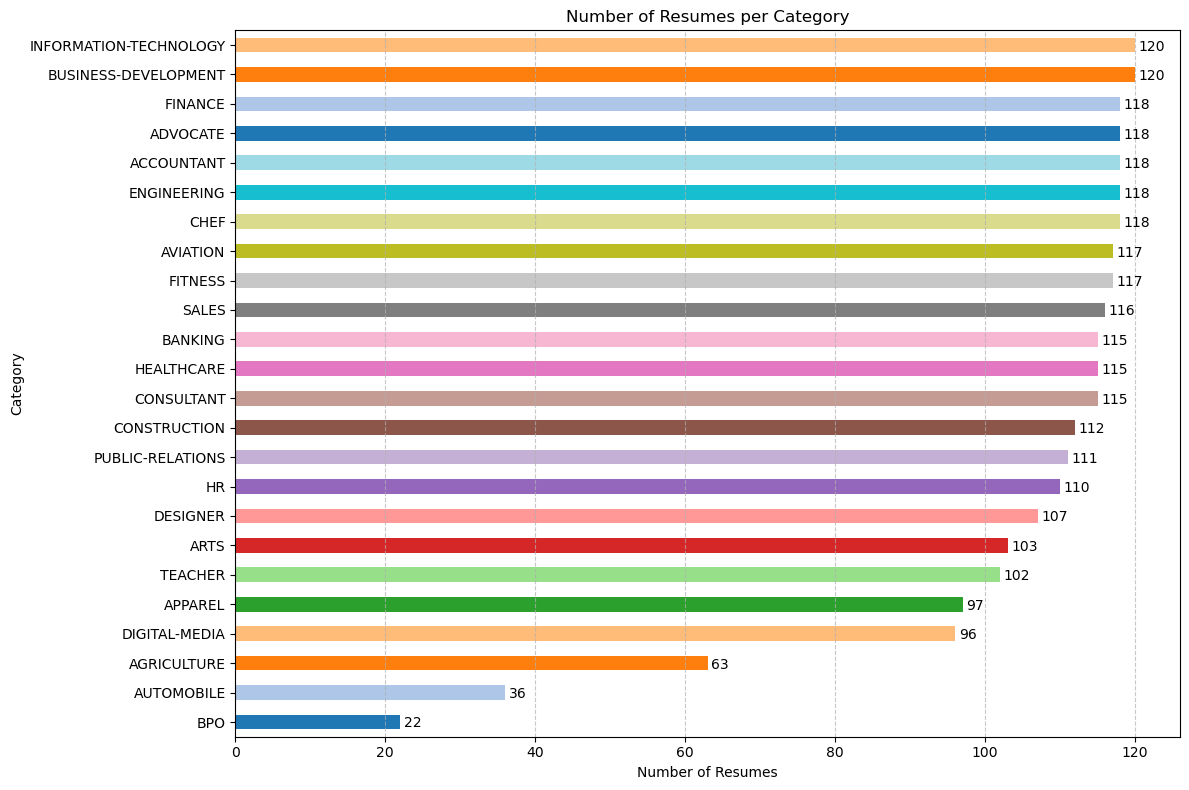

In [ ]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
# Sort the categories by count
ax =category_counts.sort_values().plot(kind='barh', color=plt.cm.tab20.colors)
plt.title('Number of Resumes per Category')
plt.xlabel('Number of Resumes')
plt.ylabel('Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels to each bar
for i in ax.patches:
    plt.text(i.get_width() + 0.5, i.get_y() + 0.2, str(int(i.get_width())), va='center', color='black')

plt.tight_layout()
plt.show()

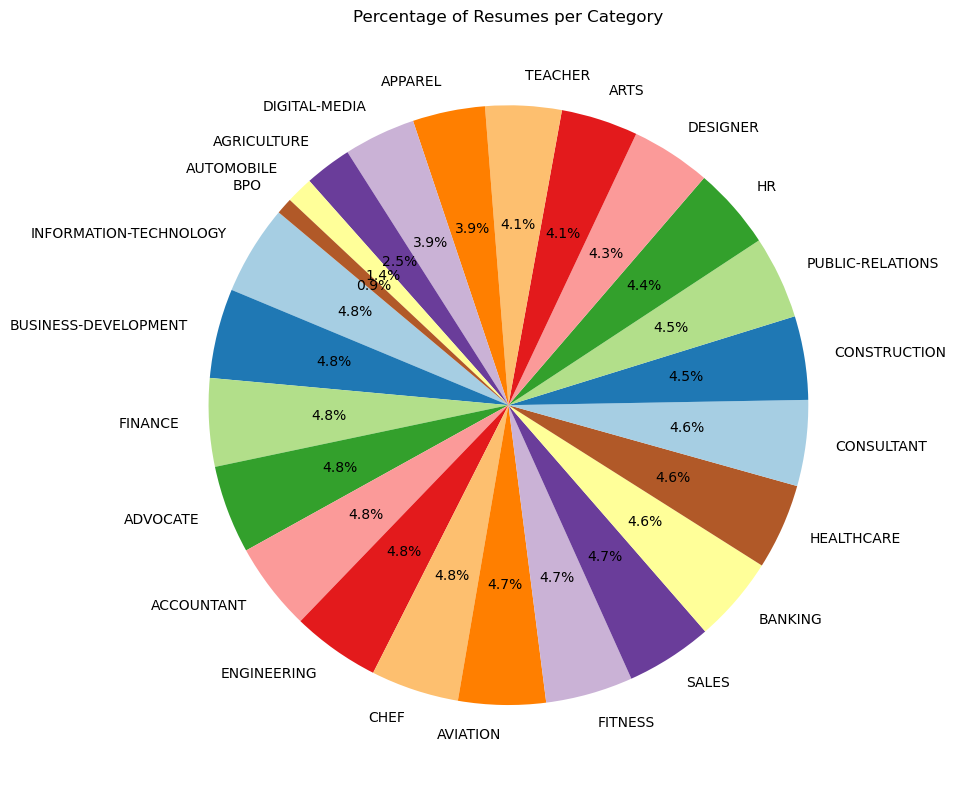

In [ ]:
# Plotting the pie chart for category distribution
plt.figure(figsize=(10, 8))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage of Resumes per Category')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
# Remove redundant columns
resume_df.drop(['ID', 'Resume_html'], axis=1, inplace=True)
resume_df

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR
...,...,...
2479,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,AVIATION
2480,"GOVERNMENT RELATIONS, COMMUNICATIONS ...",AVIATION
2481,GEEK SQUAD AGENT Professional...,AVIATION
2482,PROGRAM DIRECTOR / OFFICE MANAGER ...,AVIATION


#### Preprocessing

In [ ]:

def preprocess_resume(resume_df):
    '''
    Using RegEx to remove special chars and punctuation
    '''
    # Remove "(<.*?>)" markup
    resume_df['Resume_str'] = resume_df['Resume_str'].apply(lambda x: re.sub('(<.*?>)', ' ', x))
    # Remove punctuation marks
    resume_df['Resume_str'] = resume_df['Resume_str'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
    # Remove whitespace
    resume_df['Resume_str'] = resume_df['Resume_str'].apply(lambda x: x.strip())
    # Remove all strings that contain a non-letter
    resume_df['Resume_str'] = resume_df['Resume_str'].apply(lambda x: re.sub('[^a-zA-Z"]',' ',x))
    # Convert to lowercase
    resume_df['Resume_str'] = resume_df['Resume_str'].apply(lambda x: x.lower())

    '''
    Stemming
    '''
    # Initialize the stemmer and stopwords list
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize text
    words = resume_df['Resume_str'].apply(lambda x: text_to_word_sequence(x))

    # Remove stop words
    filtered_words = words.apply(lambda x: [w for w in x if not w in stop_words])

    # Stem words
    stemmed_words = filtered_words.apply(lambda x: [stemmer.stem(w) for w in x])

    # Reconstruct text
    resume_df['Resume_stemming'] = stemmed_words.apply(lambda x: " ".join(x))

    '''
    POS Tagging + Lemmatizer
    '''
    # Initialize the lemmatizer
    lemmatizer= WordNetLemmatizer()

    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

    def tagged_lemma(string):
        pos_tagged = nltk.pos_tag(nltk.word_tokenize(string))
        wordnet_tagged = [(word, pos_tagger(tag)) for word, tag in pos_tagged]
        lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
        return " ".join(lemmatized_words)

    resume_df['Resume_lemmatization'] = resume_df['Resume_str'].apply(tagged_lemma)

    words_lemmatized = resume_df['Resume_lemmatization'].apply(lambda x: text_to_word_sequence(x))
    filtered_words_lemmatized = words_lemmatized.apply(lambda x: [w for w in x if not w in stop_words])
    resume_df['Resume_lemmatization'] = filtered_words_lemmatized.apply(lambda x: " ".join(x))

    return resume_df


processed_resume_df = preprocess_resume(resume_df.copy())


In [ ]:
processed_resume_df

,Resume_str,Category,Resume_stemming,Resume_lemmatization
0,hr administrator marketing associate hr admin...,HR,hr administr market associ hr administr summar...,hr administrator marketing associate hr admini...
1,hr specialist us hr operations summary ...,HR,hr specialist us hr oper summari versatil medi...,hr specialist us hr operation summary versatil...
2,hr director summary over years e...,HR,hr director summari year experi recruit plu ye...,hr director summary year experience recruit pl...
3,hr specialist summary dedicated drive...,HR,hr specialist summari dedic driven dynam year ...,hr specialist summary dedicate driven dynamic ...
4,hr manager skill highlights ...,HR,hr manag skill highlight hr skill hr depart st...,hr manager skill highlight hr skill hr departm...
...,...,...,...,...
2479,rank sgt e non commissioned officer in char...,AVIATION,rank sgt e non commiss offic charg brigad mail...,rank sgt e non commission officer charge briga...
2480,government relations communications and organi...,AVIATION,govern relat commun organiz develop director p...,government relation communication organization...
2481,geek squad agent professional profile ...,AVIATION,geek squad agent profession profil support spe...,geek squad agent professional profile support ...
2482,program director office manager su...,AVIATION,program director offic manag summari highli pe...,program director office manager summary highly...


In [ ]:
# Remove original Resume_str column
processed_resume_df.drop('Resume_str', axis=1, inplace=True)
# Save preprocessed data to CSV
processed_resume_df.to_csv('Resume_preprocessed.csv', index=False)
processed_resume_df

,Category,Resume_stemming,Resume_lemmatization
0,HR,hr administr market associ hr administr summar...,hr administrator marketing associate hr admini...
1,HR,hr specialist us hr oper summari versatil medi...,hr specialist us hr operation summary versatil...
2,HR,hr director summari year experi recruit plu ye...,hr director summary year experience recruit pl...
3,HR,hr specialist summari dedic driven dynam year ...,hr specialist summary dedicate driven dynamic ...
4,HR,hr manag skill highlight hr skill hr depart st...,hr manager skill highlight hr skill hr departm...
...,...,...,...
2479,AVIATION,rank sgt e non commiss offic charg brigad mail...,rank sgt e non commission officer charge briga...
2480,AVIATION,govern relat commun organiz develop director p...,government relation communication organization...
2481,AVIATION,geek squad agent profession profil support spe...,geek squad agent professional profile support ...
2482,AVIATION,program director offic manag summari highli pe...,program director office manager summary highly...


# Section 2

# Category PDF

## Data Cleaning and Vectorizing

In [ ]:
# Read Preprocessed Dataset
df = pd.read_csv('Resume_preprocessed.csv')
# We don't need stemming result
df = df.drop(columns=['Resume_stemming'])
# Drop NaN Value
df = df.dropna()
df.head()

,Category,Resume_lemmatization
0,HR,hr administrator marketing associate hr admini...
1,HR,hr specialist us hr operation summary versatil...
2,HR,hr director summary year experience recruit pl...
3,HR,hr specialist summary dedicate driven dynamic ...
4,HR,hr manager skill highlight hr skill hr departm...


In [ ]:
# Encode the categories to numbers
label = LabelEncoder()
df['Label'] = label.fit_transform(df['Category'])
df.head()

,Category,Resume_lemmatization,Label
0,HR,hr administrator marketing associate hr admini...,19
1,HR,hr specialist us hr operation summary versatil...,19
2,HR,hr director summary year experience recruit pl...,19
3,HR,hr specialist summary dedicate driven dynamic ...,19
4,HR,hr manager skill highlight hr skill hr departm...,19


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2483 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Category              2483 non-null   object
 1   Resume_lemmatization  2483 non-null   object
 2   Label                 2483 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


In [ ]:
# Vectorizing the preprocessed resumes using TF-IDF
resumes = df['Resume_lemmatization'].values
labels = df['Label'].values
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=2000)
features = vectorizer.fit_transform(resumes)
features.shape

(2483, 2000)

In [ ]:
# Showing TF-IDF scores
tfidf_scores = pd.DataFrame(features.toarray().transpose(),index=vectorizer.get_feature_names_out())
tfidf_scores

,0,1,2,3,4,5,6,7,8,9,...,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482
ability,0.000000,0.0,0.000000,0.048299,0.000000,0.000000,0.000000,0.000000,0.030890,0.03205,...,0.0,0.000000,0.000000,0.075216,0.000000,0.032443,0.030553,0.0,0.032740,0.050979
able,0.000000,0.0,0.041243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.031753,0.000000,0.071556,0.037212,0.080538,0.000000,0.0,0.000000,0.044146
absence,0.072701,0.0,0.000000,0.105068,0.000000,0.000000,0.073053,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.070575,0.000000,0.0,0.000000,0.000000
abuse,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
academic,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
year,0.024456,0.0,0.053714,0.035344,0.019066,0.000000,0.000000,0.043005,0.038273,0.00000,...,0.0,0.015848,0.022725,0.035714,0.000000,0.000000,0.022358,0.0,0.050280,0.037306
yearly,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.097837,0.050878,0.000000,0.000000,0.0,0.000000,0.000000
york,0.000000,0.0,0.000000,0.000000,0.000000,0.065088,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
young,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


## Training Traditional Machine Learning Models for Classification

In [ ]:
# Separate train and test data
labels = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42, test_size=0.2)

In [ ]:
print('TF-IDF Train:',X_train.shape)
print('TF-IDF Test:',X_test.shape)

TF-IDF Train: (1986, 2000)
TF-IDF Test: (497, 2000)


### Naive Bayes (Baseline)

In [ ]:
# Create a Naive Bayes Classifier
clf_nb = OneVsRestClassifier(MultinomialNB())
# Train the model using the training set
clf_nb.fit(X_train, y_train)
# Predict the response for test set
y_pred = clf_nb.predict(X_test)

print('Accuracy of training set : {:.2f}'.format(clf_nb.score(X_train, y_train) * 100))
print('Accuracy of test set : {:.2f}'.format(clf_nb.score(X_test, y_test) * 100))

print("Classification report for classifier %s:\n%s\n" % (clf_nb, metrics.classification_report(y_test, y_pred)))

Accuracy of training set : 67.62
Accuracy of test set : 56.20
Classification report for classifier OneVsRestClassifier(estimator=MultinomialNB()):
              precision    recall  f1-score   support

           0       0.72      0.92      0.81        39
           1       0.63      0.36      0.46        33
           2       1.00      0.08      0.14        13
           3       0.75      0.47      0.58        19
           4       0.20      0.04      0.07        23
           5       0.00      0.00      0.00         8
           6       0.71      0.74      0.73        27
           7       0.60      0.69      0.64        26
           8       0.00      0.00      0.00         5
           9       0.39      0.62      0.48        29
          10       0.76      0.82      0.79        34
          11       0.77      0.71      0.74        34
          12       0.00      0.00      0.00        27
          13       0.90      0.64      0.75        28
          14       0.82      0.33      0.4

F1 Micro: 0.5619967793880838
F1 Macro: 0.479026119816677


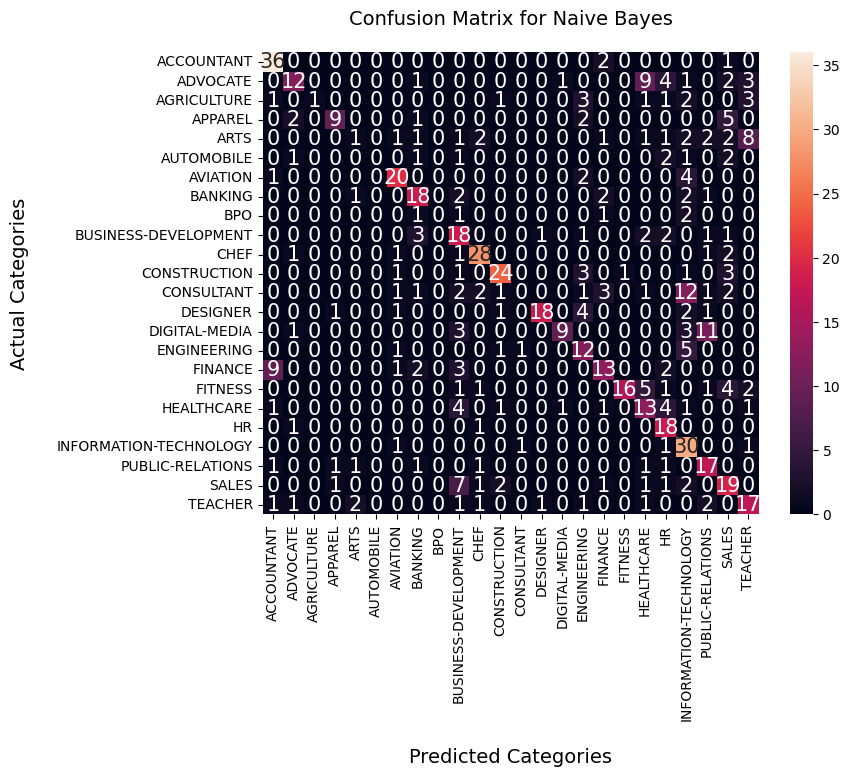

In [ ]:
micro = f1_score(y_test, y_pred, average='micro')
macro = f1_score(y_test, y_pred, average='macro')
print('F1 Micro: '+ str(micro))
print('F1 Macro: '+ str(macro))

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6), dpi=100)
ax = sns.heatmap(conf_mat, annot = True, fmt=".0f", annot_kws={"size": 15})
ax.set_ylabel("Actual Categories", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(label.classes_, rotation='horizontal')
ax.set_xlabel("Predicted Categories", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(label.classes_, rotation='vertical')
# set plot title
ax.set_title("Confusion Matrix for Naive Bayes", fontsize=14, pad=20)
plt.show()

### SVM

In [ ]:
# Create a svm Classifier
clf_svm = svm.SVC(kernel='rbf') # RBF kernel
# Train the model using the training set
clf_svm.fit(X_train, y_train)
# Predict the response for test set
y_pred = clf_svm.predict(X_test)

print('Accuracy of training set : {:.2f}'.format(clf_svm.score(X_train, y_train) * 100))
print('Accuracy of test set : {:.2f}'.format(clf_svm.score(X_test, y_test) * 100))

print("Classification report for classifier %s:\n%s\n" % (clf_svm, metrics.classification_report(y_test, y_pred)))


Accuracy of training set : 98.50
Accuracy of test set : 61.67
Classification report for classifier SVC():
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        39
           1       0.55      0.48      0.52        33
           2       1.00      0.15      0.27        13
           3       0.65      0.58      0.61        19
           4       0.30      0.26      0.28        23
           5       0.00      0.00      0.00         8
           6       0.79      0.81      0.80        27
           7       0.64      0.69      0.67        26
           8       0.00      0.00      0.00         5
           9       0.48      0.52      0.50        29
          10       0.88      0.82      0.85        34
          11       0.84      0.79      0.82        34
          12       0.33      0.33      0.33        27
          13       0.88      0.75      0.81        28
          14       0.73      0.59      0.65        27
          15       0.46      

F1 Micro: 0.6167471819645732
F1 Macro: 0.5558569184621627


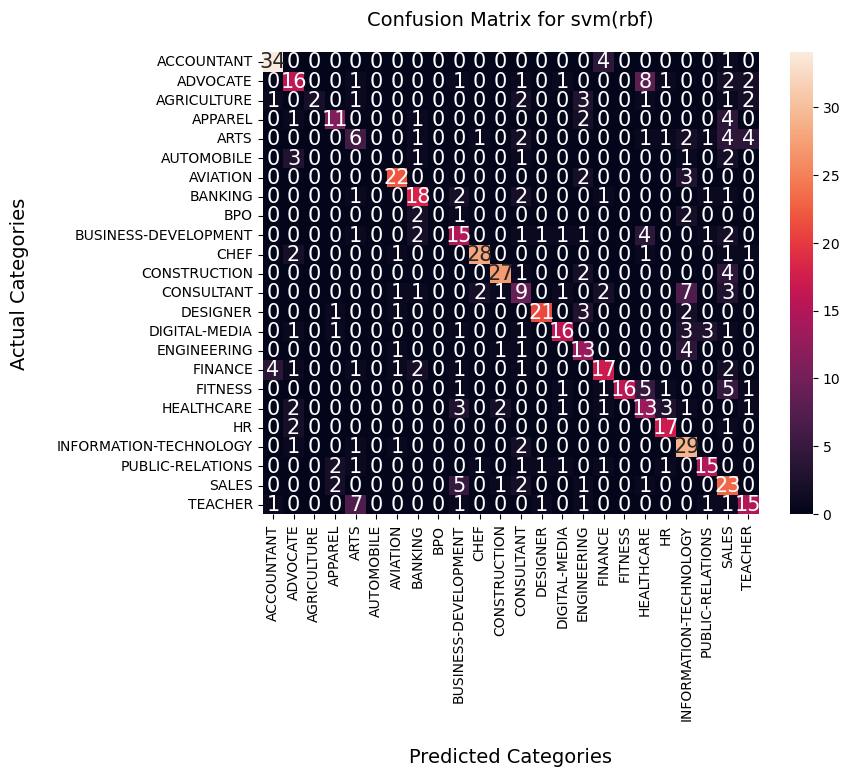

In [ ]:
micro = f1_score(y_test, y_pred, average='micro')
macro = f1_score(y_test, y_pred, average='macro')
print('F1 Micro: '+ str(micro))
print('F1 Macro: '+ str(macro))

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6), dpi=100)
ax = sns.heatmap(conf_mat, annot = True, fmt=".0f", annot_kws={"size": 15})
ax.set_ylabel("Actual Categories", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(label.classes_, rotation='horizontal')
ax.set_xlabel("Predicted Categories", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(label.classes_, rotation='vertical')
# set plot title
ax.set_title("Confusion Matrix for svm(rbf)", fontsize=14, pad=20)
plt.show()

### Linear svm Classifier

In [ ]:
# Create a Linear svm Classifier
clf_linear = svm.LinearSVC()
# Train the model using the training set
clf_linear.fit(X_train, y_train)
# Predict the response for test set
y_pred = clf_linear.predict(X_test)

print('Accuracy of training set : {:.2f}'.format(clf_linear.score(X_train, y_train) * 100))
print('Accuracy of test set : {:.2f}'.format(clf_linear.score(X_test, y_test) * 100))

print("Classification report for classifier %s:\n%s\n" % (clf_linear, metrics.classification_report(y_test, y_pred)))

Accuracy of training set : 99.95
Accuracy of test set : 68.28
Classification report for classifier LinearSVC():
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        39
           1       0.62      0.70      0.66        33
           2       0.67      0.31      0.42        13
           3       0.68      0.68      0.68        19
           4       0.47      0.30      0.37        23
           5       0.50      0.12      0.20         8
           6       0.81      0.81      0.81        27
           7       0.62      0.81      0.70        26
           8       0.00      0.00      0.00         5
           9       0.72      0.45      0.55        29
          10       0.85      0.85      0.85        34
          11       0.81      0.88      0.85        34
          12       0.52      0.41      0.46        27
          13       0.81      0.79      0.80        28
          14       0.63      0.63      0.63        27
          15       0.45

F1 Micro: 0.6827697262479872
F1 Macro: 0.6220947816339679


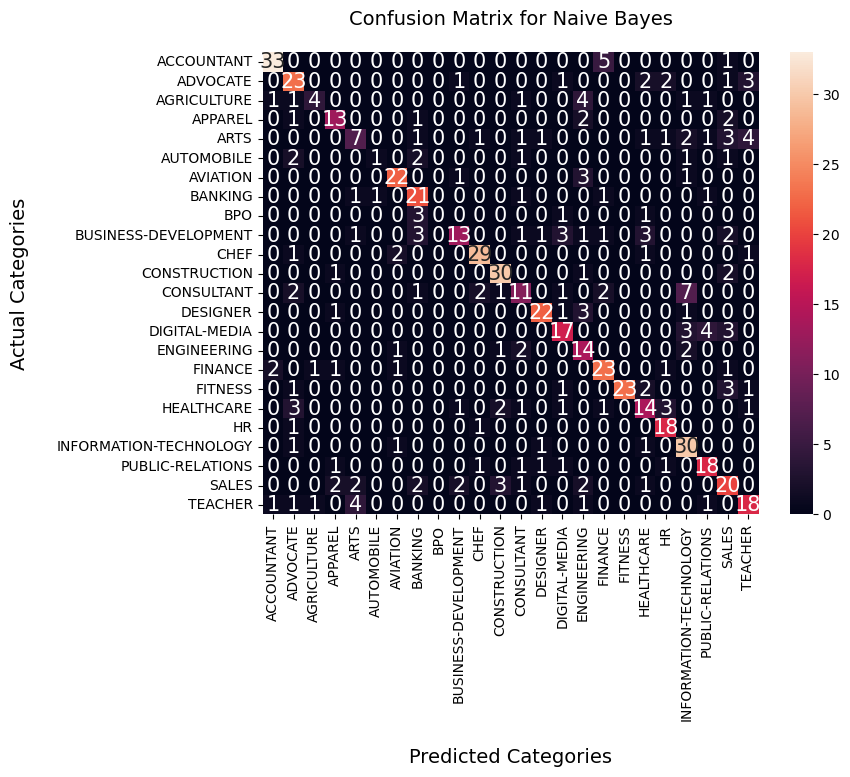

In [ ]:
micro = f1_score(y_test, y_pred, average='micro')
macro = f1_score(y_test, y_pred, average='macro')
print('F1 Micro: '+ str(micro))
print('F1 Macro: '+ str(macro))

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6), dpi=100)
ax = sns.heatmap(conf_mat, annot = True, fmt=".0f", annot_kws={"size": 15})
ax.set_ylabel("Actual Categories", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(label.classes_, rotation='horizontal')
ax.set_xlabel("Predicted Categories", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(label.classes_, rotation='vertical')
# set plot title
ax.set_title("Confusion Matrix for Naive Bayes", fontsize=14, pad=20)
plt.show()

# Training Deep Learning Modal for Classification

In [ ]:
# Creating dataset for deep learning model
df_dl = df
df_dl.reset_index(drop=True, inplace=True)
df_dl.rename(columns={'Label': 'label'}, inplace=True)


dataset = Dataset.from_pandas(df_dl)

In [ ]:
# Split the dataset into 80% training, 10% validation, 10% test
dataset_train_testvalid = dataset.train_test_split(test_size=0.2)
dataset_test_valid = dataset_train_testvalid['test'].train_test_split(test_size=0.5)

train_test_valid_dataset = DatasetDict({
    'train': dataset_train_testvalid['train'],
    'test': dataset_test_valid['test'],
    'valid': dataset_test_valid['train']})
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['Category', 'Resume_lemmatization', 'label'],
        num_rows: 1986
    })
    test: Dataset({
        features: ['Category', 'Resume_lemmatization', 'label'],
        num_rows: 249
    })
    valid: Dataset({
        features: ['Category', 'Resume_lemmatization', 'label'],
        num_rows: 248
    })
})

In [ ]:
# Apply tokenizer on the dataset to perform the text encoding
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['Resume_lemmatization'], padding=True, truncation=True, max_length=256)

resumes_encoded = train_test_valid_dataset.map(tokenize, batched=True, batch_size=None)

# Convert data type into torch tensor for training
resumes_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

resumes_encoded['train'].column_names

['Category', 'Resume_lemmatization', 'Label', 'input_ids', 'attention_mask']

# Utilize Pre-Trained DistelBert Model For Sequence Classification

In [ ]:
# Build the distilbert model using pre-trained sequence classification model
model_ckpt = "distilbert-base-uncased"

num_labels = 24
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
# Set the hyperparameters for tuning
batch_size = 64
logging_steps = len(resumes_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-resumes"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=resumes_encoded['train'],
    eval_dataset=resumes_encoded['valid'],
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.121600,2.981223,0.270161,0.236341
2,2.806800,2.469804,0.629032,0.562068
3,2.325400,1.974429,0.697581,0.640164
4,1.899300,1.585337,0.754032,0.705221
5,1.577500,1.339818,0.778226,0.742211


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.121600,2.981223,0.270161,0.236341
2,2.806800,2.469804,0.629032,0.562068
3,2.325400,1.974429,0.697581,0.640164
4,1.899300,1.585337,0.754032,0.705221
5,1.577500,1.339818,0.778226,0.742211
6,1.340500,1.177591,0.798387,0.776669
7,1.159400,1.083550,0.806452,0.783781
8,1.045300,1.034710,0.802419,0.780341
9,1.018700,1.002771,0.814516,0.795155
10,0.952300,0.992854,0.814516,0.797081


TrainOutput(global_step=320, training_loss=1.7048127621412277, metrics={'train_runtime': 432.3029, 'train_samples_per_second': 45.94, 'train_steps_per_second': 0.74, 'total_flos': 1315917351567360.0, 'train_loss': 1.7048127621412277, 'epoch': 10.0})

# Evaluation

In [ ]:
# Evaluation
preds_output = trainer.predict(resumes_encoded["test"])
preds_output.metrics

{'test_loss': 0.9374282956123352,
 'test_accuracy': 0.8232931726907631,
 'test_f1': 0.807252944732568,
 'test_runtime': 1.9207,
 'test_samples_per_second': 129.639,
 'test_steps_per_second': 2.083}

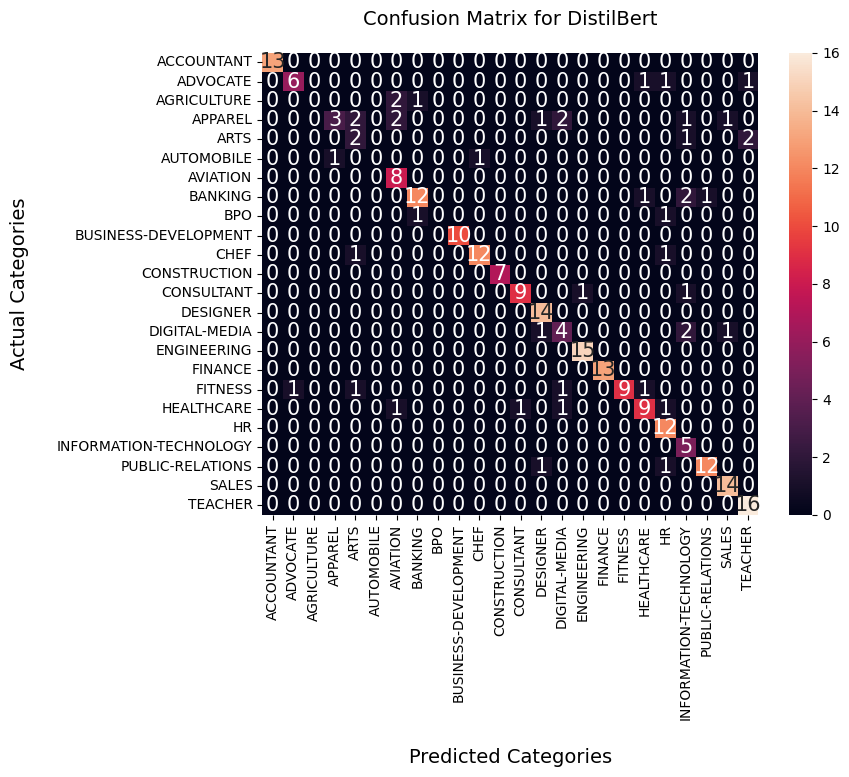

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_test = preds_output.label_ids

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6), dpi=100)
ax = sns.heatmap(conf_mat, annot = True, fmt=".0f", annot_kws={"size": 15})
ax.set_ylabel("Actual Categories", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(label.classes_, rotation='horizontal')
ax.set_xlabel("Predicted Categories", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(label.classes_, rotation='vertical')
# set plot title
ax.set_title("Confusion Matrix for DistilBert", fontsize=14, pad=20)
plt.show()

# Section 3

## Custom NER

In [ ]:
data = ResumeParser('jagadeesh k.docx').get_extracted_data()
print(data)

{'name': 'JAGADEESH  ', 'email': 'Jagadeesh14917@gmail.com', 'mobile_number': '216-6679', 'skills': ['Visual', 'French', 'Engineering', 'Shell', 'Technical', 'Javascript', 'Windows', 'Css', 'Operations', 'Logging', 'Xml', 'Controls', 'Documentation', 'Architecture', 'Visio', 'Docker', 'Transactions', 'Cloud', 'Mysql', 'System', 'Coding', 'Queries', 'Security', 'Testing', 'Os', 'Presentation', 'Js', 'Writing', 'Resource management', 'Database', 'Software engineering', 'Html5', 'R', 'Modeling', 'Scrum', 'Api', 'Networking', 'Json', 'Payments', 'Life cycle', 'Interactive', 'Process', 'Java', 'Html', 'Analysis', 'Twitter', 'Soap', 'Solaris', 'Linux', 'Policies', 'Web services', 'Pl/sql', 'Unix', 'Sql', 'Postgresql', 'Servers', 'Nosql', 'Github', 'Jira', 'Design', 'Ui', 'Sdlc', 'Ibm', 'Project management', 'Front-end', 'Rest', 'Agile', 'Jose', 'Test plans', 'Communication', 'Jsp', 'Analytical', 'Reports', 'Scripting', 'Debugging', 'English', 'Cisco', 'Oracle', 'Aws', 'Db2', 'Pattern', 'Acce

In [ ]:
skills = data['skills']
college_name = data['college_name']
degree = data['degree']
company_names = data['company_names']
total_experience = data['total_experience']

print('skill: '+str(skills))
print('college_name: '+str(college_name))
print('degree: '+str(degree))
print('company_names: '+str(company_names))
print('total_experience: '+str(total_experience))


skill: ['Visual', 'French', 'Engineering', 'Shell', 'Technical', 'Javascript', 'Windows', 'Css', 'Operations', 'Logging', 'Xml', 'Controls', 'Documentation', 'Architecture', 'Visio', 'Docker', 'Transactions', 'Cloud', 'Mysql', 'System', 'Coding', 'Queries', 'Security', 'Testing', 'Os', 'Presentation', 'Js', 'Writing', 'Resource management', 'Database', 'Software engineering', 'Html5', 'R', 'Modeling', 'Scrum', 'Api', 'Networking', 'Json', 'Payments', 'Life cycle', 'Interactive', 'Process', 'Java', 'Html', 'Analysis', 'Twitter', 'Soap', 'Solaris', 'Linux', 'Policies', 'Web services', 'Pl/sql', 'Unix', 'Sql', 'Postgresql', 'Servers', 'Nosql', 'Github', 'Jira', 'Design', 'Ui', 'Sdlc', 'Ibm', 'Project management', 'Front-end', 'Rest', 'Agile', 'Jose', 'Test plans', 'Communication', 'Jsp', 'Analytical', 'Reports', 'Scripting', 'Debugging', 'English', 'Cisco', 'Oracle', 'Aws', 'Db2', 'Pattern', 'Access']
college_name: None
degree: None
company_names: ['Amazon', 'Oracle']
total_experience: 0


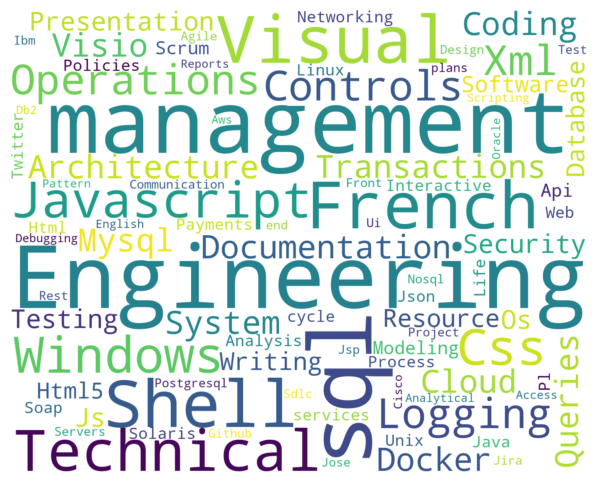

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = " ".join(skills)

wordcloud = WordCloud(width = 1500, height = 1200, background_color ='white').generate(text)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Section 4

## Job Description Matching

In [ ]:
file="Resume_preprocessed.csv"
df=pd.read_csv(file)


job_description_text = ("Software engineering, Agile methodology, Scrum, Git, Version Control, "
                        "Software Testing, Continuous Integration/Continuous Deployment (CI/CD), "
                        "DevOps,Java, Python, C++, JavaScript, SQL, HTML/CSS, Ruby, PHP, Swift, Kotlin,"
                        "Front-end development, Back-end development, Full-stack development, Web frameworks (e.g., Django, Flask, React, Angular), "
                        "Responsive design, Cross-browser compatibility, RESTful APIs,Database administration, "
                        "SQL databases (e.g., MySQL, PostgreSQL, Oracle), NoSQL databases (e.g., MongoDB, Cassandra), "
                        "Data modeling, Database optimization, Query optimization,Network administration, TCP/IP, DNS, "
                        "DHCP, LAN/WAN, VPN, Firewall configuration, Network security, Routing and switching, Cisco, "
                        "Juniper,Cybersecurity, Penetration testing, Vulnerability assessment, Security protocols (e.g., SSL/TLS), "
                        "Intrusion detection and prevention systems (IDPS), Security policies and procedures, Risk management, "
                        "Compliance (e.g., GDPR, HIPAA),Cloud platforms (e.g., AWS, Azure, Google Cloud), Infrastructure as a Service (IaaS), "
                        "Platform as a Service (PaaS), Software as a Service (SaaS), Cloud architecture, Cloud security, Cloud migration,"
                        "Data visualization, Data mining, Machine learning, Artificial intelligence, Big data, Data warehousing, "
                        "Business intelligence (BI) tools (e.g., Tableau, Power BI), Statistical analysis, Predictive modeling, "
                        "Server administration (Windows Server, Linux/Unix), Virtualization (VMware, Hyper-V), Containerization (Docker, Kubernetes), "
                        "System monitoring, Disaster recovery, High availability, System backups, Help desk support, "
                        "Ticketing systems (e.g., ServiceNow, Zendesk), Troubleshooting, Remote support, End-user training, Documentation, Customer service")

job_description_text=re.sub('(<.*?>)', ' ', job_description_text)
job_description_text=re.sub('[,\.!?:()"]', '', job_description_text)
job_description_text=re.sub('[^a-zA-Z"]',' ',job_description_text)

print(job_description_text)

Software engineering Agile methodology Scrum Git Version Control Software Testing Continuous Integration Continuous Deployment CI CD DevOpsJava Python C   JavaScript SQL HTML CSS Ruby PHP Swift KotlinFront end development Back end development Full stack development Web frameworks eg Django Flask React Angular Responsive design Cross browser compatibility RESTful APIsDatabase administration SQL databases eg MySQL PostgreSQL Oracle NoSQL databases eg MongoDB Cassandra Data modeling Database optimization Query optimizationNetwork administration TCP IP DNS DHCP LAN WAN VPN Firewall configuration Network security Routing and switching Cisco JuniperCybersecurity Penetration testing Vulnerability assessment Security protocols eg SSL TLS Intrusion detection and prevention systems IDPS Security policies and procedures Risk management Compliance eg GDPR HIPAACloud platforms eg AWS Azure Google Cloud Infrastructure as a Service IaaS Platform as a Service PaaS Software as a Service SaaS Cloud arch

In [ ]:
start_row=219
end_row=338
similarities=[]

for i in range(start_row,end_row+1):
    resume=df.iloc[i-2,2]
    print(resume)
    # Create TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Convert resume text and job description text to TF-IDF vectors
    tfidf_matrix = tfidf_vectorizer.fit_transform([job_description_text,resume])

    # Calculate cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

    print("Matching Score:", cosine_sim[0][0])

    cell='D{}'.format(i)
    df[cell]=cosine_sim[0][0]

    similarities.append(cosine_sim[0][0])


best_match=np.argmax(similarities)
print("The best Matching Score:",similarities[best_match])

information technology summary dedicate information assurance professional well verse analyze mitigate risk find cost effective solution excels boost performance productivity establish realistic goal enforce deadline versatile professional year enterprise design engineering methodology skill enterprise platform knowledge product lifecycle management plm project track hardware software upgrade planning product requirement documentation self direct visio decisive collaborative domain active directory layout data storage engineering information assurance risk management framework rmf active directory design deployment workstation build deployment system accreditation package red hat enterprise linux installation hardening network design troubleshoot high performance compute experience company name city state information technology current hire manage accreditation effort major department modernization project involve accreditation package lead successful authorization operate decision res

In [ ]:
mean_value=np.mean(similarities)
print("The mean matching score:",mean_value)
median_value=np.median(similarities)
print("The median matching score:",median_value)

The mean matching score: 0.11888325804789426
The median matching score: 0.12233836046135146


# Section 5

## Personality Analysis

### Data analysis

In [ ]:
data_set = pd.read_csv("mbti_1.csv")
data_set.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
data_set.isnull().any()

type     False
posts    False
dtype: bool

In [ ]:
data_set.shape

(8675, 2)

In [ ]:
data_set.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [ ]:
types = np.unique(np.array(data_set['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [ ]:
total = data_set.groupby(['type']).count()
total

,posts
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


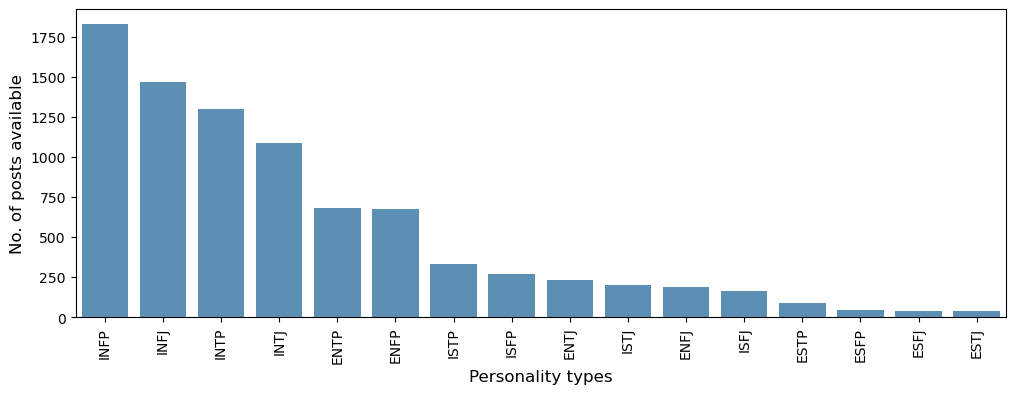

In [ ]:

no_post = data_set['type'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(12, 4))
sns.barplot(x=no_post.index, y=no_post.values, alpha=0.8)
plt.xlabel('Personality types', fontsize=12)
plt.ylabel('No. of posts available', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()


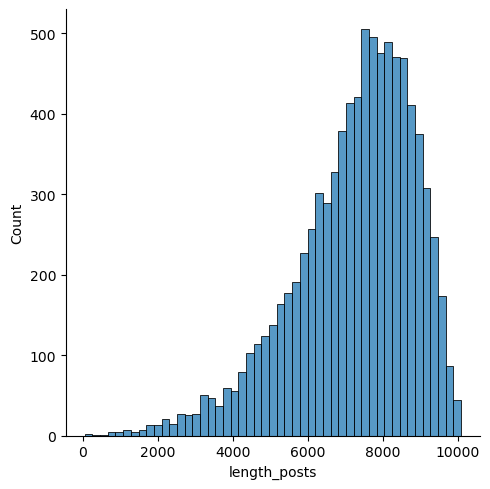

In [ ]:
#Finding the length of every post
df = data_set
df["length_posts"] = df["posts"].apply(len)
sns.displot(df["length_posts"])

### Four Classifiers for every Personality

### Data reading & interpreting

In [ ]:
data = pd.read_csv("mbti_1.csv")
data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [ ]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0

    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found')

    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')

    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')

    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J })

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


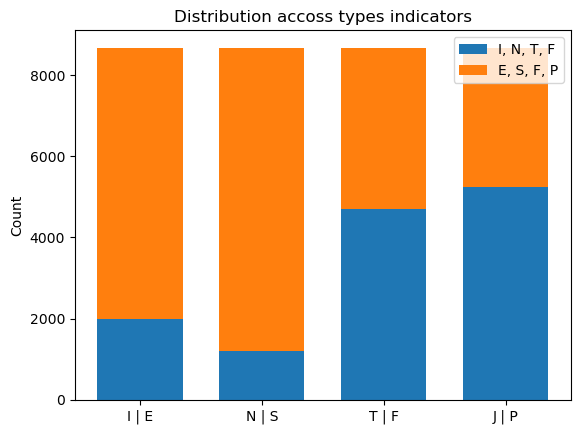

In [ ]:
#Plotting the distribution of each personality type indicator
No = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

i = np.arange(No)
width = 0.7

p1 = plt.bar(i, bottom, width, label="I, N, T, F")
p2 = plt.bar(i, top, width, bottom=bottom, label="E, S, F, P")

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(i, ('I | E',  'N | S', 'T | F', 'J | P',))
plt.legend()

plt.show()

### Pre processing

In [ ]:
lemmatiser = WordNetLemmatizer()

stop_words = stopwords.words("english")

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

In [ ]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s


In [ ]:
#Cleaning of data
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)
  i=0

  for row in data.iterrows():
      posts = row[1].posts
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
      temp = re.sub("[^a-zA-Z]", " ", temp)
      temp = re.sub(' +', ' ', temp).lower()
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in stop_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")
      type_labelized = translate_personality(row[1].type)
      list_personality.append(type_labelized)
      list_posts.append(temp)
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nBefore preprocessing:\n\n", data.posts[0])
print("\nAfter preprocessing:\n\n", list_posts[0])

Example :

Before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads

In [ ]:
personality_type = [ "IE: Introversion (I) | Extroversion (E)", "NS: Intuition (N) | Sensing (S)",
                   "FT: Feeling (F) | Thinking (T)", "JP: Judging (J) | Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) | Extroversion (E)
NS: Intuition (N) | Sensing (S)
FT: Feeling (F) | Thinking (T)
JP: Judging (J) | Perceiving (P)


### Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cntizer = CountVectorizer(analyzer="word",
                          max_features=1000,
                          max_df=0.7,
                          min_df=0.1)

X_cnt = cntizer.fit_transform(list_posts)

tfizer = TfidfTransformer()

X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)


(8675, 595)


### Training

In [ ]:
# Posts in tf-idf representation
X = X_tfidf

IE: Introversion (I) | Extroversion (E) Accuracy: 76.35%
NS: Intuition (N) | Sensing (S) Accuracy: 85.25%
FT: Feeling (F) | Thinking (T) Accuracy: 69.66%
FT: Feeling (F) | Thinking (T) F1 score: 0.66


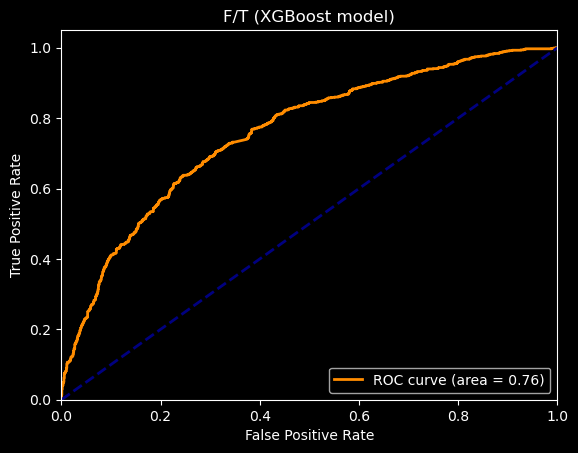

JP: Judging (J) | Perceiving (P) Accuracy: 60.49%
JP: Judging (J) | Perceiving (P) F1 score: 0.70


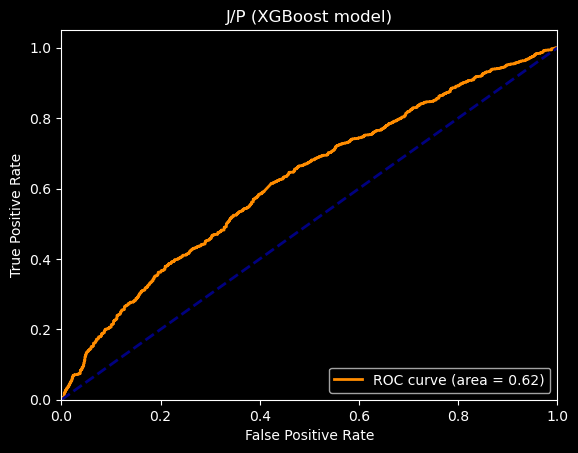

In [ ]:
# XGBoost model
for l in range(len(personality_type)):
    Y = list_personality[:, l]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=8)

    model = XGBClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

    if l == 2 or l == 3:
        f1 = f1_score(y_test, predictions, average='binary')
        print("%s F1 score: %.2f" % (personality_type[l], f1))

        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if l == 2:
            plt.title('F/T (XGBoost model)')
        else:
            plt.title('J/P (XGBoost model)')
        plt.legend(loc="lower right")
        plt.show()



IE: Introversion (I) | Extroversion (E) Accuracy: 77.82%
NS: Intuition (N) | Sensing (S) Accuracy: 85.80%
FT: Feeling (F) | Thinking (T) Accuracy: 73.17%
FT: Feeling (F) | Thinking (T) F1 score: 0.70


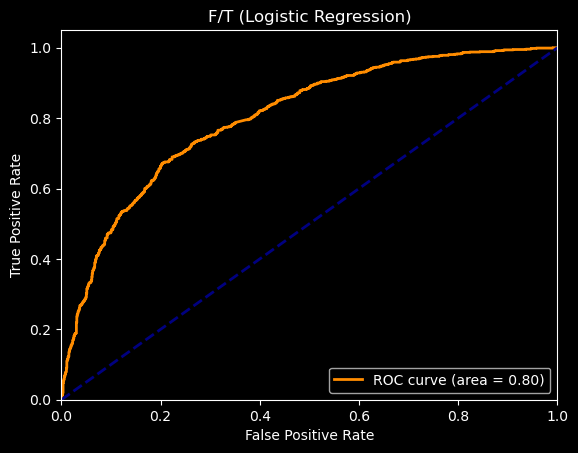

JP: Judging (J) | Perceiving (P) Accuracy: 63.95%
JP: Judging (J) | Perceiving (P) F1 score: 0.73


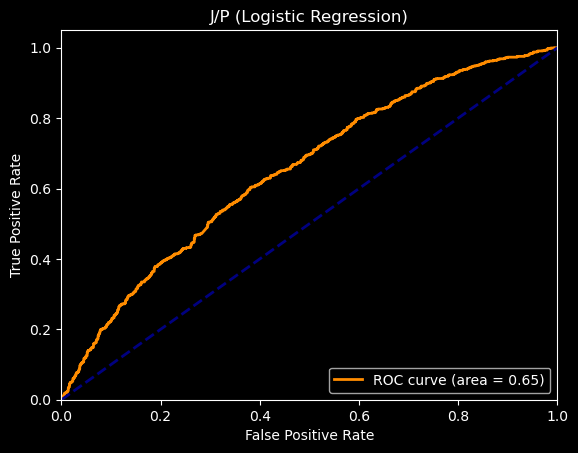

In [ ]:
# Logistic Regression
for l in range(len(personality_type)):
    Y = list_personality[:, l]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=8)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]

    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

    if l == 2 or l == 3:
        f1 = f1_score(y_test, predictions, average='binary')
        print("%s F1 score: %.2f" % (personality_type[l], f1))

        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if l == 2:
            plt.title('F/T (Logistic Regression)')
        else:
            plt.title('J/P (Logistic Regression)')

        plt.legend(loc="lower right")
        plt.show()



IE: Introversion (I) | Extroversion (E) Accuracy: 77.32%
NS: Intuition (N) | Sensing (S) Accuracy: 85.89%
FT: Feeling (F) | Thinking (T) Accuracy: 73.31%
FT: Feeling (F) | Thinking (T) F1 score: 0.71


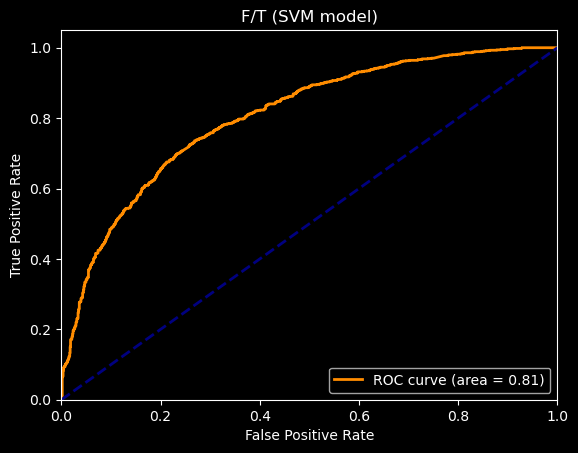

JP: Judging (J) | Perceiving (P) Accuracy: 65.15%
JP: Judging (J) | Perceiving (P) F1 score: 0.75


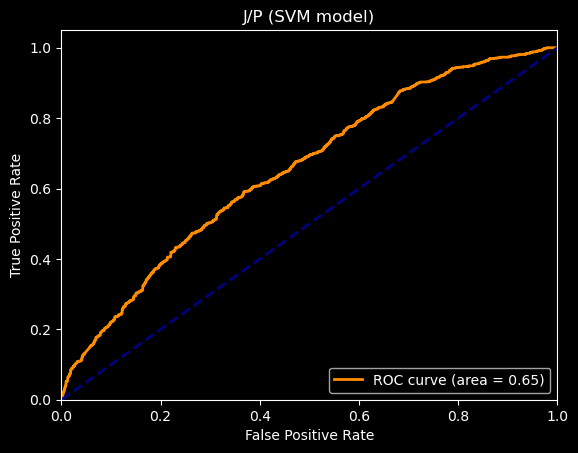

In [ ]:
# SVM model
for l in range(len(personality_type)):
    Y = list_personality[:, l]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=8)

    model = SVC(random_state=1, probability=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]

    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

    if l == 2 or l == 3:
        f1 = f1_score(y_test, predictions, average='binary')
        print("%s F1 score: %.2f" % (personality_type[l], f1))

        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if l == 2:
            plt.title('F/T (SVM model)')
        else:
            plt.title('J/P (SVM model)')
        plt.legend(loc="lower right")
        plt.show()



### Main model with fine tuning of Hyperparameters

In [ ]:
def getConfMatrix(pred_data, actual):
    conf_mat = confusion_matrix(actual, pred_data, labels=[0,1])
    accuracy = accuracy_score(actual, pred_data)
    precision = precision_score(actual, pred_data, average='micro')
    recall = recall_score(actual, pred_data, average='micro')

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 18})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))


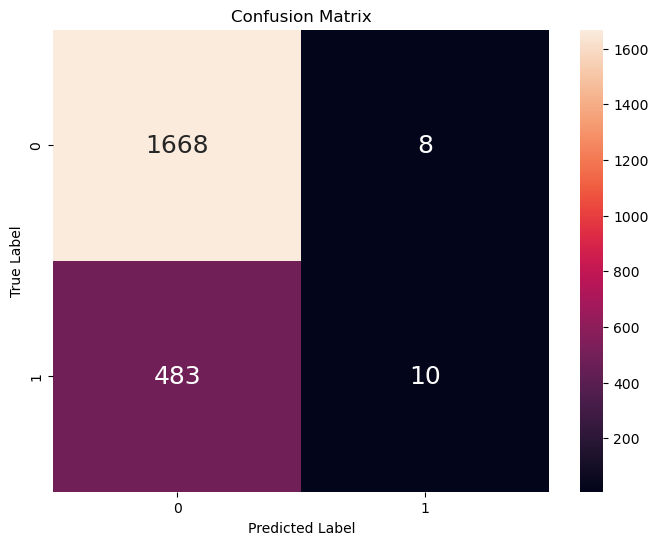

Accuracy: 0.7736284001844168
Precision: 0.7736284001844168
Recall: 0.7736284001844168
F1 Micro: 0.7736284001844168
F1 Macro: 0.4554200072918909
IE: Introversion (I) | Extroversion (E) Accuracy: 77.36%


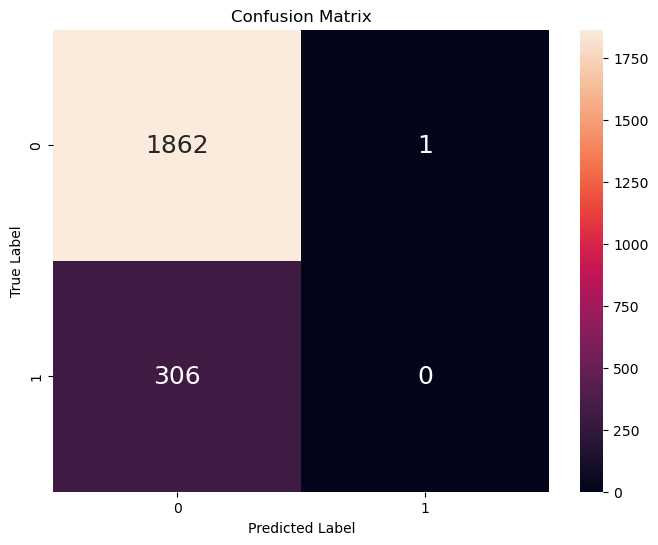

Accuracy: 0.8584601198709082
Precision: 0.8584601198709082
Recall: 0.8584601198709082
F1 Micro: 0.8584601198709082
F1 Macro: 0.4619201190771521
NS: Intuition (N) | Sensing (S) Accuracy: 85.85%


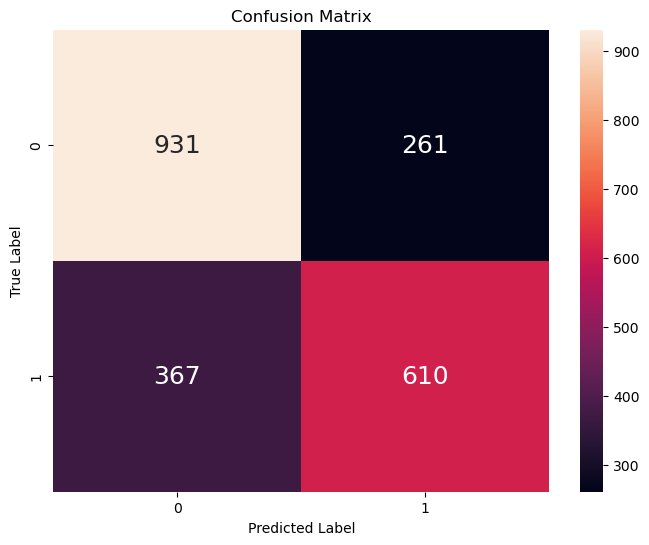

Accuracy: 0.7104656523743661
Precision: 0.7104656523743661
Recall: 0.7104656523743661
F1 Micro: 0.7104656523743661
F1 Macro: 0.7039821624158973
FT: Feeling (F) | Thinking (T) Accuracy: 71.05%


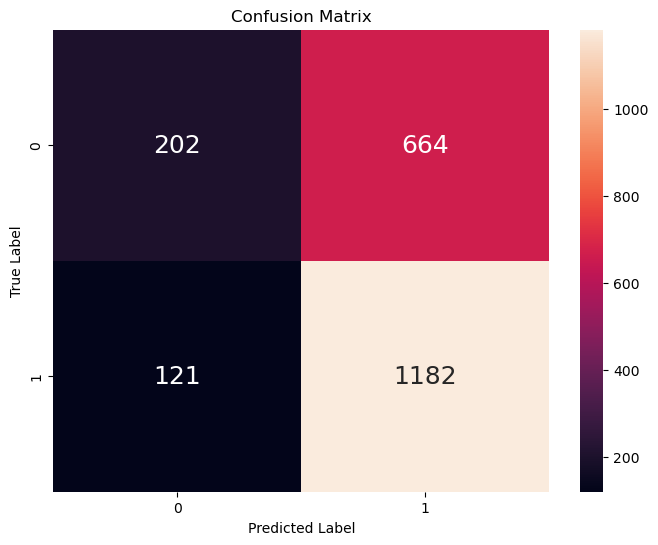

Accuracy: 0.6380820654679575
Precision: 0.6380820654679575
Recall: 0.6380820654679575
F1 Micro: 0.6380820654679575
F1 Macro: 0.5452479206957179
JP: Judging (J) | Perceiving (P) Accuracy: 63.81%


In [ ]:
# parameters for xgboost
param = {}

param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.1

for l in range(len(personality_type)):
    Y = list_personality[:,l]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=8)

    model = XGBClassifier(**param)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    accuracy = accuracy_score(y_test, predictions)
    getConfMatrix(predictions,y_test)
    micro = f1_score(y_test, predictions, average='micro')
    macro = f1_score(y_test,predictions, average='macro')
    print('F1 Micro: '+ str(micro))
    print('F1 Macro: '+ str(macro))
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

In [ ]:
def Personality_Type(out):
    if out == 'ISTJ':
        return 'Responsible, sincere, analytical, reserved, realistic, systematic. Hardworking and trustworthy with sound practical judgment.'
    elif out == 'ISFJ':
        return 'Warm, considerate, gentle, responsible, pragmatic, thorough. Devoted caretakers who enjoy being helpful to others.'
    elif out == 'INFJ':
        return 'Idealistic, organized, insightful, dependable, compassionate, gentle. Seek harmony and cooperation, enjoy intellectual stimulation.'
    elif out == 'INTJ':
        return 'Innovative, independent, strategic, logical, reserved, insightful. Driven by their own original ideas to achieve improvements.'
    elif out == 'ISTP':
        return 'Action-oriented, logical, analytical, spontaneous, reserved, independent. Enjoy adventure, skilled at understanding how mechanical things work.'
    elif out == 'ISFP':
        return 'Gentle, sensitive, nurturing, helpful, flexible, realistic. Seek to create a personal environment that is both beautiful and practical.'
    elif out == 'INFP':
        return 'Sensitive, creative, idealistic, perceptive, caring, loyal. Value inner harmony and personal growth, focus on dreams and possibilities.'
    elif out == 'INTP':
        return 'Intellectual, logical, precise, reserved, flexible, imaginative. Original thinkers who enjoy speculation and creative problem solving.'
    elif out == 'ESTP':
        return 'Outgoing, realistic, action-oriented, curious, versatile, spontaneous. Pragmatic problem solvers and skillful negotiators.'
    elif out == 'ESFP':
        return 'Playful, enthusiastic, friendly, spontaneous, tactful, flexible. Have strong common sense, enjoy helping people in tangible ways.'
    elif out == 'ENFP':
        return 'Enthusiastic, creative, spontaneous, optimistic, supportive, playful. Value inspiration, enjoy starting new projects, see potential in others.'
    elif out == 'ENTP':
        return 'Inventive, enthusiastic, strategic, enterprising, inquisitive, versatile. Enjoy new ideas and challenges, value inspiration.'
    elif out == 'ESTJ':
        return 'Efficient, outgoing, analytical, systematic, dependable, realistic. Like to run the show and get things done in an orderly fashion.'
    elif out == 'ESFJ':
        return 'Friendly, outgoing, reliable, conscientious, organized, practical. Seek to be helpful and please others, enjoy being active and productive.'
    elif out == 'ENFJ':
        return 'Caring, enthusiastic, idealistic, organized, diplomatic, responsible. Skilled communicators who value connection with people.'
    else:
        return 'Strategic, logical, efficient, outgoing, ambitious, independent. Effective organizers of people and long-range planners.'




### Prediction

In [ ]:
print('Craft a 500-word essay outlining why you believe you are well-suited for the NLP engineer role, focusing on attributes beyond technical skills. Detail the value you would bring to the company in terms of innovation, problem-solving, collaboration, and continuous learning.')

Craft a 500-word essay outlining why you believe you are well-suited for the NLP engineer role, focusing on attributes beyond technical skills. Detail the value you would bring to the company in terms of innovation, problem-solving, collaboration, and continuous learning.


In [ ]:
# 1

my_posts  = """ Hey there! So, let's talk about why I'm a perfect fit for this NLP engineer role, beyond just my tech skills. First off, I'm like a language enthusiast on turbo mode! The way words weave stories and connect people? Absolutely blows my mind. That's why diving into NLP feels like unlocking a treasure trove of possibilities, where tech meets human expression in the coolest ways.

Now, buckle up because I'm not just about crunching code. My background? It's a wild mix of psychology, linguistics, and cognitive science. Yeah, I know, it's like having a supercharged brain buffet! This mash-up gives me this crazy ability to understand not just how machines think but also how humans tick. That means when I build NLP models, they don't just work; they click with people, making tech feel more like a buddy than a robot.

But wait, there's more! I'm a chatterbox, but in a good way. I thrive in teams where ideas fly faster than Wi-Fi signals. Communication? It's my jam! I'm all about keeping everyone in the loop, listening, and tossing ideas around like confetti. Because let's face it, the best solutions come from a brainiac brainstorm, right?

Now, let's talk impact. I'm not just here to write lines of code; I'm on a mission. Whether it's making user experiences smoother than butter or breaking down language barriers for inclusivity, count me in! NLP isn't just about tech wizardry; it's about changing lives, and that's where I shine brightest.

Oh, and did I mention I'm a learning junkie? The NLP world moves faster than a Formula 1 race, and I'm here for the ride. Constantly learning, adapting, and staying ahead of the curve? It's my thing.

So, in a nutshell, I'm the NLP dynamo you've been looking for. Passion for language? Check. Interdisciplinary ninja skills? Double-check. Communication champ? You bet! Impact-driven and always hungry to learn? Absolutely! I'm ready to dive in, collaborate like a boss, and turn NLP dreams into reality. Let's do this!"""

mydata = pd.DataFrame(data={'type': ['ISFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = cntizer.transform(my_posts)
my_X1_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [ ]:
result = []

for l in range(len(personality_type)):
    y_pred = model.predict(my_X1_tfidf)
    result.append(y_pred[0])

In [ ]:
out = translate_back(result)
out_1 = Personality_Type(out)
print("The result is: ", out)
print("The person personality may be: ", out_1)

The result is:  ESTP
The person personality may be:  Outgoing, realistic, action-oriented, curious, versatile, spontaneous. Pragmatic problem solvers and skillful negotiators.


In [ ]:
# 2

my_posts  = """ As an engineer, I view the NLP engineer role through a strategic lens, focusing on how I can leverage my analytical skills and vision to drive meaningful impact. My introverted nature allows me to delve deep into complex algorithms, unraveling patterns and refining solutions with precision. I thrive in environments that value strategic planning, innovation, and continuous improvement.

While I may not be the most outwardly expressive, I bring a strategic and calculated approach to team collaboration, valuing clear communication, logical reasoning, and data-driven decision-making. I excel in translating abstract concepts into actionable plans, aligning technology with strategic objectives.

Driven by a thirst for knowledge and a desire for mastery, I am excited about the possibilities that NLP presents. I aim to contribute my analytical prowess, strategic thinking, and innovative mindset to drive transformative advancements in NLP technologies, aligning with the company's long-term goals and vision."""

mydata = pd.DataFrame(data={'type': ['ISFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = cntizer.transform(my_posts)
my_X1_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [ ]:
result = []

for l in range(len(personality_type)):
    y_pred = model.predict(my_X1_tfidf)
    result.append(y_pred[0])


In [ ]:
out = translate_back(result)
out_1 = Personality_Type(out)
print("The result is: ", out)
print("The person personality may be: ", out_1)

The result is:  INFJ
The person personality may be:  Idealistic, organized, insightful, dependable, compassionate, gentle. Seek harmony and cooperation, enjoy intellectual stimulation.


In [ ]:
# 3

my_posts  = """ My qualifications extend beyond the technical skills on my resume. My passion for language grants me a deep understanding of its nuances, allowing me to identify patterns in natural language data that might elude purely technical approaches. This translates to more accurate and insightful NLP solutions, like sentiment analysis that grasps context and emotion.

However, NLP thrives at the intersection of creativity and computation. I excel at both. I can brainstorm unconventional solutions and translate them into workable prototypes through efficient coding. This willingness to experiment pushes boundaries and accelerates development.

The ever-evolving field of NLP demands continuous learning. I'm a dedicated learner, staying updated on advancements through research and industry engagement. This ensures I bring the most relevant solutions to the table and contribute meaningfully to your team's success. Additionally, I can explain complex NLP concepts clearly, fostering knowledge sharing within diverse teams.

Finally, I'm a strong team player. While I can work independently, I truly shine in collaborative environments. My communication skills allow me to effectively exchange ideas, integrate feedback, and work seamlessly towards shared goals. I value the contributions of others and believe the best solutions come from diverse perspectives.

In essence, I bring more than just technical expertise. I offer an innovative mindset, a thirst for knowledge, effective communication, and a collaborative spirit. My unique blend of skills and dedication make me a perfect fit for your company, and I'm eager to become a valuable asset to your team."""
mydata = pd.DataFrame(data={'type': ['ISFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = cntizer.transform(my_posts)
my_X1_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [ ]:
result = []

for l in range(len(personality_type)):
    y_pred = model.predict(my_X1_tfidf)
    result.append(y_pred[0])


In [ ]:
out = translate_back(result)
out_1 = Personality_Type(out)
print("The result is: ", out)
print("The person personality may be: ", out_1)

The result is:  INFJ
The person personality may be:  Idealistic, organized, insightful, dependable, compassionate, gentle. Seek harmony and cooperation, enjoy intellectual stimulation.


# Section 6

In [ ]:
dataset_path = 'Resume_preprocessed.csv'
# Load your dataset
resumes_df = pd.read_csv(dataset_path)

In [ ]:
# Define keywords
keywords =[
    "Web Development", "Program Management", "Project Management", "Detailed-Oriented",
    "Technology Needs Analysis", "Solution Implementation", "Leadership", "Team Building",
    "Staff Development", "Process Improvement", "Requirements Gathering", "Strategic Planning",
    "Multitasking", "Data Analysis", "Software Supervision", "Software Development Lifecycle (SDLC)",
    "Budget Management", "Website Management", "Staff Training", "Report Generation",
    "Graduate", "Paperless Initiatives", "Faculty", "Technical Specifications",
    "Customer Service", "Internal and External Communications", "Intranet Deployment",
    "Corporate Web Design Standards", "Microsoft FrontPage", "IT Strategy Initiatives",
    "Electronic", "Academic Publishing", "Web Technologies",
    "Software Programming", "IT Analyst", "User Experience Design", "Quality Assurance",
    "IT Policy Development", "Information Security", "System Architecture", "Network Management",
    "IT Consultation", "Client Relationship Management", "IT Infrastructure", "IT Education and Training",
    "Technical Support", "information technology", "network", "system", "hardware", "software",
    "telecommunications", "LAN", "cisco", "project management", "quality assurance", "licensed electrician",
    "alarm management", "technical assistance", "troubleshooting", "preventative maintenance", "budget",
    "client system", "technical support", "cyber transport", "security", "client communication", "documentation",
    "electrical engineering", "network infrastructure", "router", "video system", "supply quality assurance",
    "telecom", "cyber", "system design", "circuit management", "wireless", "privilege access", "installation",
    "system upgrade", "reliability", "efficiency", "system integrity", "ticket system", "NIPR network",
    "focal point", "data system", "mission requirement", "optimization", "compatibility", "architecture",
    "corrective measure", "problem solving", "feasibility study", "equipment fund", "infrastructure",
    "system anomaly", "system failure", "trend analysis", "hardware software budget", "technical feasibility",
    "technology enhancement", "vulnerability", "risk assessment", "encryption", "patch management",
    "data backup", "electronic principle", "training", "certification", "electronic device", "software installation",
    "explosive device", "electrostatic discharge", "supply system", "monitoring", "system technician",
    "routing", "cabling", "networking", "gpa", "python", "deep learning", 'java', 'python', 'sql', 'aws', 'linux', 'javascript', 'html', 'css', 'machine learning', 'networking',
    'c++', '.net', 'ruby', 'php', 'android', 'ios', 'xamarin', 'flutter', 'react', 'angular', 'vue', 'node.js',
    'docker', 'kubernetes', 'git', 'jenkins', 'azure', 'google cloud', 'swift', 'scala', 'r', 'matlab', 'bash',
    'perl', 'mongodb', 'redis', 'hadoop', 'spark', 'tableau', 'power bi', 'ansible', 'terraform', 'salesforce',
    'typescript', 'jquery', 'wordpress', 'magento', 'drupal','computer science', 'information systems', 'software engineering', 'bachelor', 'master', 'degree',
    'cybersecurity', 'data science', 'network engineering', 'computer engineering', 'artificial intelligence',
    'robotics', 'cloud computing', 'information technology', 'systems administration', 'electrical engineering',
    'bioinformatics', 'applied mathematics', 'statistics', 'physics', 'web development', 'software development',
    'programming', 'machine learning', 'computer graphics', 'human-computer interaction', 'bioengineering',
    'digital design', 'game design', 'software testing', 'project management', 'computer architecture',
    'algorithms', 'operating systems', 'data structures', 'software design', 'system analysis', 'ethical hacking',
    'network security', 'IT management', 'cloud architecture', 'DevOps', 'data analysis', 'virtualization',
    'blockchain technology'
]

In [ ]:
# Filter for IT resumes
it_resumes_df = resumes_df[resumes_df['Category'] == "INFORMATION-TECHNOLOGY"]

In [ ]:
# Score resumes
it_resumes_df['Score'] = it_resumes_df['Resume_lemmatization'].apply(lambda x: sum(2 for keyword in keywords if keyword in x))

In [ ]:
# Get the top 50 IT resumes based on scores
top_it_resumes = it_resumes_df.sort_values(by='Score', ascending=False).head(50)

In [ ]:

print(top_it_resumes[['Category', 'Resume_lemmatization', 'Score']])

                   Category  \
218  INFORMATION-TECHNOLOGY   
297  INFORMATION-TECHNOLOGY   
282  INFORMATION-TECHNOLOGY   
258  INFORMATION-TECHNOLOGY   
281  INFORMATION-TECHNOLOGY   
234  INFORMATION-TECHNOLOGY   
314  INFORMATION-TECHNOLOGY   
304  INFORMATION-TECHNOLOGY   
254  INFORMATION-TECHNOLOGY   
331  INFORMATION-TECHNOLOGY   
241  INFORMATION-TECHNOLOGY   
267  INFORMATION-TECHNOLOGY   
316  INFORMATION-TECHNOLOGY   
249  INFORMATION-TECHNOLOGY   
326  INFORMATION-TECHNOLOGY   
244  INFORMATION-TECHNOLOGY   
301  INFORMATION-TECHNOLOGY   
327  INFORMATION-TECHNOLOGY   
236  INFORMATION-TECHNOLOGY   
298  INFORMATION-TECHNOLOGY   
334  INFORMATION-TECHNOLOGY   
232  INFORMATION-TECHNOLOGY   
333  INFORMATION-TECHNOLOGY   
280  INFORMATION-TECHNOLOGY   
253  INFORMATION-TECHNOLOGY   
321  INFORMATION-TECHNOLOGY   
231  INFORMATION-TECHNOLOGY   
222  INFORMATION-TECHNOLOGY   
250  INFORMATION-TECHNOLOGY   
277  INFORMATION-TECHNOLOGY   
225  INFORMATION-TECHNOLOGY   
259  INF

# Final Product

## Cleaning and preprocessing Resume

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    # Remove "(<.*?>)" markup
    text = re.sub('(<.*?>)', ' ', text)
    # Remove punctuation marks
    text = re.sub('[,\.!?:()"]', '', text)
    # Remove all strings that contain a non-letter
    text = re.sub('[^a-zA-Z"]',' ',text)
    # Convert to lowercase
    text = text.lower()

    # Initialize the stemmer and stopwords list
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize text
    words = text_to_word_sequence(text)

    # Remove stop words
    filtered_words = [w for w in words if not w in stop_words]

    # Stem words
    stemmed_words = [stemmer.stem(w) for w in filtered_words]

    # Reconstruct text
    processed_text = " ".join(stemmed_words)

    return processed_text

# Function to extract information from resume PDF and create DataFrame
def process_resume_pdf_list(pdf_files):
    # Initialize lists to store extracted and preprocessed data
    processed_texts = []
    names = []
    emails = []
    skills = []
    degrees = []
    total_experiences = []

    # Process each PDF file
    for pdf_file in pdf_files:
        # Extract text from PDF
        text = ''
        with pdfplumber.open(pdf_file) as pdf:
            for page in pdf.pages:
                text += page.extract_text()

        # Preprocess extracted text
        processed_text = preprocess_text(text)

        data = ResumeParser(pdf_file).get_extracted_data()

        # Append extracted and preprocessed data to lists
        processed_texts.append(processed_text)
        names.append(data['name'])
        emails.append(data['email'])
        skills.append(data['skills'])
        total_experiences.append(data['total_experience'])

    # Create DataFrame with extracted and preprocessed data
    resume_df = pd.DataFrame({
        'Processed_Text': processed_texts,
        'Name': names,
        'Email': emails,
        'Skills': skills,
        'Total_Experience': total_experiences
    })

    return resume_df


## Matching_scores with job description

In [ ]:
job_description_text = ("Software engineering, Agile methodology, Scrum, Git, Version Control, "
                        "Software Testing, Continuous Integration/Continuous Deployment (CI/CD), "
                        "DevOps,Java, Python, C++, JavaScript, SQL, HTML/CSS, Ruby, PHP, Swift, Kotlin,"
                        "Front-end development, Back-end development, Full-stack development, Web frameworks (e.g., Django, Flask, React, Angular), "
                        "Responsive design, Cross-browser compatibility, RESTful APIs,Database administration, "
                        "SQL databases (e.g., MySQL, PostgreSQL, Oracle), NoSQL databases (e.g., MongoDB, Cassandra), "
                        "Data modeling, Database optimization, Query optimization,Network administration, TCP/IP, DNS, "
                        "DHCP, LAN/WAN, VPN, Firewall configuration, Network security, Routing and switching, Cisco, "
                        "Juniper,Cybersecurity, Penetration testing, Vulnerability assessment, Security protocols (e.g., SSL/TLS), "
                        "Intrusion detection and prevention systems (IDPS), Security policies and procedures, Risk management, "
                        "Compliance (e.g., GDPR, HIPAA),Cloud platforms (e.g., AWS, Azure, Google Cloud), Infrastructure as a Service (IaaS), "
                        "Platform as a Service (PaaS), Software as a Service (SaaS), Cloud architecture, Cloud security, Cloud migration,"
                        "Data visualization, Data mining, Machine learning, Artificial intelligence, Big data, Data warehousing, "
                        "Business intelligence (BI) tools (e.g., Tableau, Power BI), Statistical analysis, Predictive modeling, "
                        "Server administration (Windows Server, Linux/Unix), Virtualization (VMware, Hyper-V), Containerization (Docker, Kubernetes), "
                        "System monitoring, Disaster recovery, High availability, System backups, Help desk support, "
                        "Ticketing systems (e.g., ServiceNow, Zendesk), Troubleshooting, Remote support, End-user training, Documentation, Customer service")

job_description_text=re.sub('(<.*?>)', ' ', job_description_text)
job_description_text=re.sub('[,\.!?:()"]', '', job_description_text)
job_description_text=re.sub('[^a-zA-Z"]',' ',job_description_text)

print(job_description_text)

def calculate_matching_score(processed_texts):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform processed texts
    processed_texts_vectorized = vectorizer.fit_transform(processed_texts)

    # Calculate cosine similarity between texts
    similarity_matrix = cosine_similarity(processed_texts_vectorized, processed_texts_vectorized)

    # Calculate matching score as the mean of cosine similarity for each row
    matching_scores = np.mean(similarity_matrix, axis=1)

    # Add matching score as a new column to the DataFrame
    processed_resume_df['Matching_Score'] = matching_scores

    return processed_resume_df

Software engineering Agile methodology Scrum Git Version Control Software Testing Continuous Integration Continuous Deployment CI CD DevOpsJava Python C   JavaScript SQL HTML CSS Ruby PHP Swift KotlinFront end development Back end development Full stack development Web frameworks eg Django Flask React Angular Responsive design Cross browser compatibility RESTful APIsDatabase administration SQL databases eg MySQL PostgreSQL Oracle NoSQL databases eg MongoDB Cassandra Data modeling Database optimization Query optimizationNetwork administration TCP IP DNS DHCP LAN WAN VPN Firewall configuration Network security Routing and switching Cisco JuniperCybersecurity Penetration testing Vulnerability assessment Security protocols eg SSL TLS Intrusion detection and prevention systems IDPS Security policies and procedures Risk management Compliance eg GDPR HIPAACloud platforms eg AWS Azure Google Cloud Infrastructure as a Service IaaS Platform as a Service PaaS Software as a Service SaaS Cloud arch

## Skill matching

In [ ]:
keywords = [
    "Web Development", "Program Management", "Project Management", "Detailed-Oriented",
    "Technology Needs Analysis", "Solution Implementation", "Leadership", "Team Building",
    "Staff Development", "Process Improvement", "Requirements Gathering", "Strategic Planning",
    "Multitasking", "Data Analysis", "Software Supervision", "Software Development Lifecycle (SDLC)",
    "Budget Management", "Website Management", "Staff Training", "Report Generation",
    "Graduate", "Paperless Initiatives", "Faculty", "Technical Specifications",
    "Customer Service", "Internal and External Communications", "Intranet Deployment",
    "Corporate Web Design Standards", "Microsoft FrontPage", "IT Strategy Initiatives",
    "Electronic", "Academic Publishing", "Web Technologies",
    "Software Programming", "IT Analyst", "User Experience Design", "Quality Assurance",
    "IT Policy Development", "Information Security", "System Architecture", "Network Management",
    "IT Consultation", "Client Relationship Management", "IT Infrastructure", "IT Education and Training",
    "Technical Support", "information technology", "network", "system", "hardware", "software",
    "telecommunications", "LAN", "cisco", "project management", "quality assurance", "licensed electrician",
    "alarm management", "technical assistance", "troubleshooting", "preventative maintenance", "budget",
    "client system", "technical support", "cyber transport", "security", "client communication", "documentation",
    "electrical engineering", "network infrastructure", "router", "video system", "supply quality assurance",
    "telecom", "cyber", "system design", "circuit management", "wireless", "privilege access", "installation",
    "system upgrade", "reliability", "efficiency", "system integrity", "ticket system", "NIPR network",
    "focal point", "data system", "mission requirement", "optimization", "compatibility", "architecture",
    "corrective measure", "problem solving", "feasibility study", "equipment fund", "infrastructure",
    "system anomaly", "system failure", "trend analysis", "hardware software budget", "technical feasibility",
    "technology enhancement", "vulnerability", "risk assessment", "encryption", "patch management",
    "data backup", "electronic principle", "training", "certification", "electronic device", "software installation",
    "explosive device", "electrostatic discharge", "supply system", "monitoring", "system technician",
    "routing", "cabling", "networking", "gpa", "python", "deep learning", 'java', 'python', 'sql', 'aws', 'linux', 'javascript', 'html', 'css', 'machine learning', 'networking',
    'c++', '.net', 'ruby', 'php', 'android', 'ios', 'xamarin', 'flutter', 'react', 'angular', 'vue', 'node.js',
    'docker', 'kubernetes', 'git', 'jenkins', 'azure', 'google cloud', 'swift', 'scala', 'r', 'matlab', 'bash',
    'perl', 'mongodb', 'redis', 'hadoop', 'spark', 'tableau', 'power bi', 'ansible', 'terraform', 'salesforce',
    'typescript', 'jquery', 'wordpress', 'magento', 'drupal','computer science', 'information systems', 'software engineering', 'bachelor', 'master', 'degree',
    'cybersecurity', 'data science', 'network engineering', 'computer engineering', 'artificial intelligence',
    'robotics', 'cloud computing', 'information technology', 'systems administration', 'electrical engineering',
    'bioinformatics', 'applied mathematics', 'statistics', 'physics', 'web development', 'software development',
    'programming', 'machine learning', 'computer graphics', 'human-computer interaction', 'bioengineering',
    'digital design', 'game design', 'software testing', 'project management', 'computer architecture',
    'algorithms', 'operating systems', 'data structures', 'software design', 'system analysis', 'ethical hacking',
    'network security', 'IT management', 'cloud architecture', 'DevOps', 'data analysis', 'virtualization',
    'blockchain technology','AI Engineer', 'Data Scientist', 'NLP', 'Artificial Intelligence Engineer', 'Deep Learning Engineer',
    'Neural Networks', 'Reinforcement Learning', 'Computer Vision', 'Natural Language Processing',
    'Machine Learning Engineer', 'AI Model Development', 'Model Training', 'Model Evaluation', 'Model Optimization',
    'AI Algorithms', 'AI Frameworks', 'AI Applications', 'AI System Design', 'AI Ethics', 'AI Governance', 'AI Strategy',
    'Data Science', 'Data Analysis', 'Data Mining', 'Data Visualization', 'Statistical Analysis', 'Predictive Modeling',
    'Big Data', 'Data Warehousing', 'Data Engineering', 'Data Cleansing', 'Data Governance', 'Data Strategy',
    'Data-driven Decision Making', 'Data Ethics', 'Data Security', 'NLP Engineer', 'Text Analysis', 'Text Mining',
    'Text Processing', 'Sentiment Analysis', 'Named Entity Recognition', 'Text Classification', 'Topic Modeling',
    'Speech Recognition', 'Language Translation', 'Dialogue Systems', 'Text Analytics', 'Word Embeddings',
    'Language Models', 'Sequence-to-Sequence Models', 'Transformer Models', 'BERT', 'GPT', 'NLTK', 'Spacy', 'Stanford NLP',
    'NLP Applications', 'NLP System Design', 'NLP Ethics', 'NLP Governance', 'NLP Strategy', 'NLP Algorithms',
    'NLP Frameworks'
]

def calculate_skill_matching_score(processed_texts, keywords):
    # Initialize an empty list to store scores
    scores = []

    # Calculate matching score for each processed text
    for text in processed_texts:
        # Initialize score for current text
        score = 0

        # Calculate score based on keyword matching
        for keyword in keywords:
            if keyword.lower() in text.lower():
                score += 2

        # Normalize score to a maximum of 100
        normalized_score = min(score, 100)

        # Append normalized score to list
        scores.append(normalized_score)

    # Add scores to the DataFrame
    processed_resume_df['Skill_Score'] = scores



In [ ]:
#Cleaning and preprocessing Resum
pdf_files = ['1.pdf', '2.pdf', 'cv.pdf']

response = [""" Hey there! So, let's talk about why I'm a perfect fit for this NLP engineer role, beyond just my tech skills. First off, I'm like a language enthusiast on turbo mode! The way words weave stories and connect people? Absolutely blows my mind. That's why diving into NLP feels like unlocking a treasure trove of possibilities, where tech meets human expression in the coolest ways.

Now, buckle up because I'm not just about crunching code. My background? It's a wild mix of psychology, linguistics, and cognitive science. Yeah, I know, it's like having a supercharged brain buffet! This mash-up gives me this crazy ability to understand not just how machines think but also how humans tick. That means when I build NLP models, they don't just work; they click with people, making tech feel more like a buddy than a robot.

But wait, there's more! I'm a chatterbox, but in a good way. I thrive in teams where ideas fly faster than Wi-Fi signals. Communication? It's my jam! I'm all about keeping everyone in the loop, listening, and tossing ideas around like confetti. Because let's face it, the best solutions come from a brainiac brainstorm, right?

Now, let's talk impact. I'm not just here to write lines of code; I'm on a mission. Whether it's making user experiences smoother than butter or breaking down language barriers for inclusivity, count me in! NLP isn't just about tech wizardry; it's about changing lives, and that's where I shine brightest.

Oh, and did I mention I'm a learning junkie? The NLP world moves faster than a Formula 1 race, and I'm here for the ride. Constantly learning, adapting, and staying ahead of the curve? It's my thing.

So, in a nutshell, I'm the NLP dynamo you've been looking for. Passion for language? Check. Interdisciplinary ninja skills? Double-check. Communication champ? You bet! Impact-driven and always hungry to learn? Absolutely! I'm ready to dive in, collaborate like a boss, and turn NLP dreams into reality. Let's do this!"""



,""" As an engineer, I view the NLP engineer role through a strategic lens, focusing on how I can leverage my analytical skills and vision to drive meaningful impact. My introverted nature allows me to delve deep into complex algorithms, unraveling patterns and refining solutions with precision. I thrive in environments that value strategic planning, innovation, and continuous improvement.

While I may not be the most outwardly expressive, I bring a strategic and calculated approach to team collaboration, valuing clear communication, logical reasoning, and data-driven decision-making. I excel in translating abstract concepts into actionable plans, aligning technology with strategic objectives.

Driven by a thirst for knowledge and a desire for mastery, I am excited about the possibilities that NLP presents. I aim to contribute my analytical prowess, strategic thinking, and innovative mindset to drive transformative advancements in NLP technologies, aligning with the company's long-term goals and vision."""


,""" My qualifications extend beyond the technical skills on my resume. My passion for language grants me a deep understanding of its nuances, allowing me to identify patterns in natural language data that might elude purely technical approaches. This translates to more accurate and insightful NLP solutions, like sentiment analysis that grasps context and emotion.

However, NLP thrives at the intersection of creativity and computation. I excel at both. I can brainstorm unconventional solutions and translate them into workable prototypes through efficient coding. This willingness to experiment pushes boundaries and accelerates development.

The ever-evolving field of NLP demands continuous learning. I'm a dedicated learner, staying updated on advancements through research and industry engagement. This ensures I bring the most relevant solutions to the table and contribute meaningfully to your team's success. Additionally, I can explain complex NLP concepts clearly, fostering knowledge sharing within diverse teams.

Finally, I'm a strong team player. While I can work independently, I truly shine in collaborative environments. My communication skills allow me to effectively exchange ideas, integrate feedback, and work seamlessly towards shared goals. I value the contributions of others and believe the best solutions come from diverse perspectives.

In essence, I bring more than just technical expertise. I offer an innovative mindset, a thirst for knowledge, effective communication, and a collaborative spirit. My unique blend of skills and dedication make me a perfect fit for your company, and I'm eager to become a valuable asset to your team.""" ]

processed_resume_df = process_resume_pdf_list(pdf_files)

#Matching_scores with job description
processed_texts = processed_resume_df['Processed_Text']
processed_resume_df = calculate_matching_score(processed_texts)

#Skill matching
processed_texts = processed_resume_df['Processed_Text']
calculate_skill_matching_score(processed_texts, keywords)

In [ ]:
print(response[2])

 My qualifications extend beyond the technical skills on my resume. My passion for language grants me a deep understanding of its nuances, allowing me to identify patterns in natural language data that might elude purely technical approaches. This translates to more accurate and insightful NLP solutions, like sentiment analysis that grasps context and emotion.

However, NLP thrives at the intersection of creativity and computation. I excel at both. I can brainstorm unconventional solutions and translate them into workable prototypes through efficient coding. This willingness to experiment pushes boundaries and accelerates development.

The ever-evolving field of NLP demands continuous learning. I'm a dedicated learner, staying updated on advancements through research and industry engagement. This ensures I bring the most relevant solutions to the table and contribute meaningfully to your team's success. Additionally, I can explain complex NLP concepts clearly, fostering knowledge shari

## Personality Prediction

In [ ]:
pres = []
pres_1 = []

for l in range(len(response)):
    mydata = pd.DataFrame(data={'type': ['ISFJ'], 'posts': [response[l]]})

    my_posts, dummy = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

    my_X_cnt = cntizer.transform(my_posts)
    my_X1_tfidf = tfizer.transform(my_X_cnt).toarray()

    result = []

    for i in range(len(personality_type)):
        y_pred = model.predict(my_X1_tfidf)
        result.append(y_pred[0])

    out = translate_back(result)
    out_1 = Personality_Type(out)

    print("The result is: ", out)
    print("The person personality may be: ", out_1)

    # Append results to lists
    pres.append(out)
    pres_1.append(out_1)


processed_resume_df['personality_type'] = pres
processed_resume_df['personality_description'] = pres_1


The result is:  ESTP
The person personality may be:  Outgoing, realistic, action-oriented, curious, versatile, spontaneous. Pragmatic problem solvers and skillful negotiators.
The result is:  INFJ
The person personality may be:  Idealistic, organized, insightful, dependable, compassionate, gentle. Seek harmony and cooperation, enjoy intellectual stimulation.
The result is:  INFJ
The person personality may be:  Idealistic, organized, insightful, dependable, compassionate, gentle. Seek harmony and cooperation, enjoy intellectual stimulation.


## Category the PDF

In [ ]:
category = []
my_vocab = vectorizer.get_feature_names_out()
for l in range(len(response)):
    example_resumes = [processed_resume_df['Processed_Text'][l]]
    example_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        stop_words='english',
        max_features=2000,
        vocabulary=my_vocab
    )
    example_features = example_vectorizer.fit_transform(example_resumes)
    example_y_pred = clf_linear.predict(example_features)
    cat = label.classes_[example_y_pred[0]]
    category.append(cat)


processed_resume_df['Category'] = category

# Final Results

In [ ]:
print(processed_resume_df)

                                      Processed_Text           Name  \
0  joe blogg apart cobh co cork mob e mail jblogg...     JOE BLOGGS   
1  fa r h r n data analyst contact work experi fa...       FA R A H   
2  joshua robert j contact email joshuaro entuedu...  Joshua Robert   

                      Email  \
0        j.bloggs@yahoo.com   
1     farahmartin@email.com   
2  joshuaro001@e.ntu.edu.sg   

                                              Skills  Total_Experience  \
0  [Programming, Health, Design, Content, Word, C...              0.00   
1  [Marketing, Python, Pandas, Kpis, Analytics, E...              3.75   
2  [Programming, Marketing, Lean, Design, Python,...              0.00   

   Matching_Score  Skill_Score personality_type  \
0        0.499262           18             ESTP   
1        0.461222           12             INFJ   
2        0.478387           28             INFJ   

                             personality_description     Category  
0  Outgoing, realist